In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import re
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [128]:
# Load the merged dataframe
df = pd.read_csv('/Users/Desktop/LHL/mini_project_V/mini-project-V/merged_data.csv')

In [129]:
# Print the first few rows of the dataframe
df.head()

,customer_id,province,gender,age_group,current_reward_points,transaction_date,start_reward_points,end_reward_points,spend_type,shopping_category,spend
0,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-06,10029,5740,redemption,electronics,-428900
1,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-22,10029,10208,debit,electronics,446800
2,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-13,10029,13410,credit,sports,320200
3,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-09,10029,16673,credit,electronics,326300
4,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-21,10029,21001,credit,electronics,432800


In [130]:
# Check for null values in each column
null_counts = df.isnull().sum()

# Print the number of null values in each column
print(null_counts)

customer_id              0
province                 0
gender                   0
age_group                0
current_reward_points    0
transaction_date         0
start_reward_points      0
end_reward_points        0
spend_type               0
shopping_category        0
spend                    0
dtype: int64


In [135]:
df['spend'] = df['spend'].apply(lambda x: max(0, x))
df['current_reward_points'] = df['current_reward_points'].apply(lambda x: max(0, x))
df['end_reward_points'] = df['end_reward_points'].apply(lambda x: max(0, x))

In [136]:
# Get the descriptive statistics for the numeric columns
stats = df[['age_group', 'current_reward_points', 'start_reward_points', 'end_reward_points', 'spend']].describe()

# Print the descriptive statistics
print(stats)

       current_reward_points  start_reward_points  end_reward_points  \
count           6.252451e+06         6.252451e+06       6.252451e+06   
mean            1.000251e+04         7.998861e+03       1.862357e+04   
std             1.999539e+03         4.037010e+03       1.086242e+04   
min             0.000000e+00         1.000000e+03       0.000000e+00   
25%             8.651000e+03         4.507000e+03       1.074000e+04   
50%             1.000400e+04         7.992000e+03       1.717600e+04   
75%             1.135100e+04         1.149600e+04       2.518900e+04   
max             1.962200e+04         1.499900e+04       8.022200e+04   

              spend  
count  6.252451e+06  
mean   1.946169e+05  
std    1.643465e+05  
min    0.000000e+00  
25%    1.820000e+04  
50%    1.789000e+05  
75%    3.396000e+05  
max    4.999000e+05  


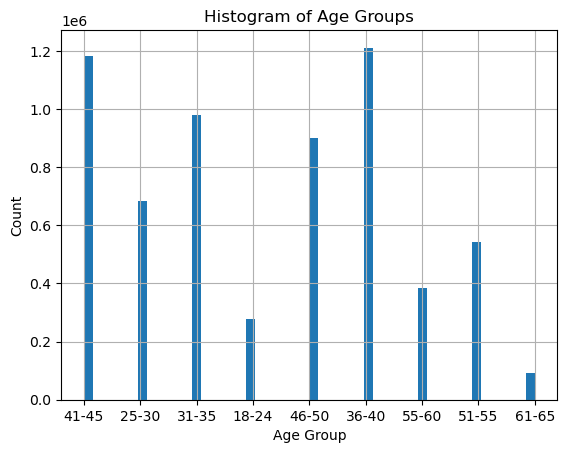

In [137]:
# Plot a histogram of the age groups
df['age_group'].hist(bins=50)

# Add axis labels and a title
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Histogram of Age Groups')

# Show the plot
plt.show()

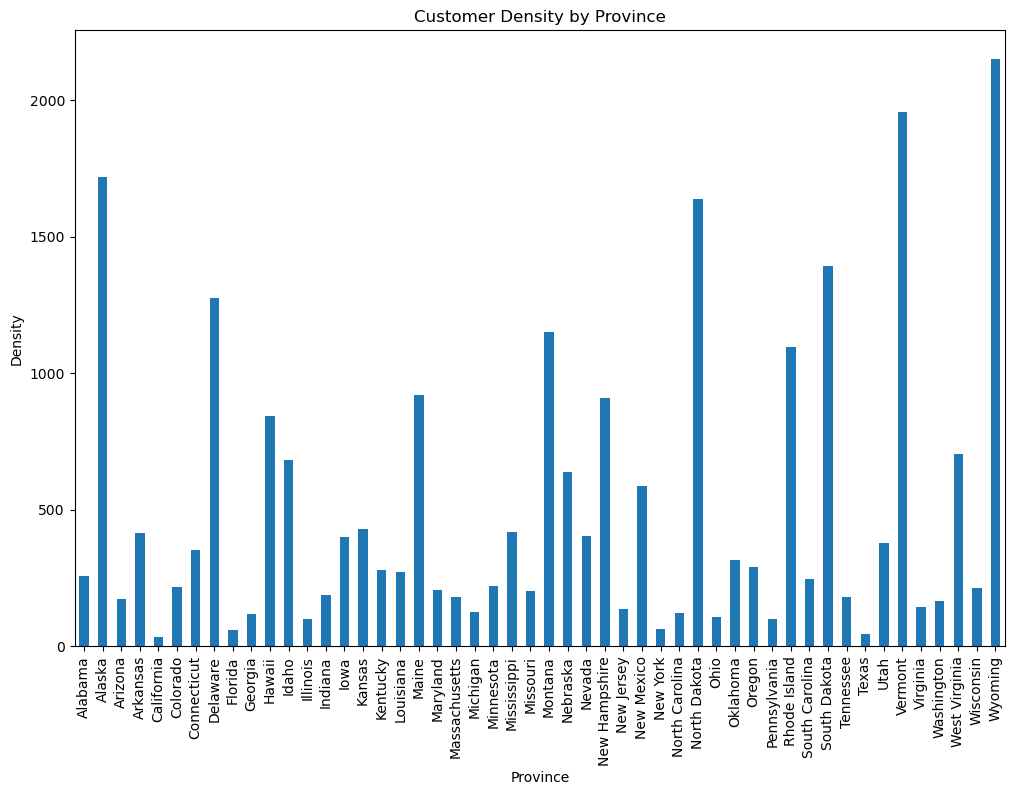

In [138]:
# Define the population data for each province
province_population = {
    'Alabama': 4903185,
    'Alaska': 731545,
    'Arizona': 7278717,
    'Arkansas': 3017825,
    'California': 39538223,
    'Colorado': 5773714,
    'Connecticut': 3605944,
    'Delaware': 989948,
    'Florida': 21538187,
    'Georgia': 10711908,
    'Hawaii': 1455271,
    'Idaho': 1839106,
    'Illinois': 12812508,
    'Indiana': 6785528,
    'Iowa': 3190369,
    'Kansas': 2937880,
    'Kentucky': 4505836,
    'Louisiana': 4648794,
    'Maine': 1362359,
    'Maryland': 6177224,
    'Massachusetts': 7029917,
    'Michigan': 10077331,
    'Minnesota': 5706494,
    'Mississippi': 2961279,
    'Missouri': 6154913,
    'Montana': 1084225,
    'Nebraska': 1961504,
    'Nevada': 3104614,
    'New Hampshire': 1377529,
    'New Jersey': 9288994,
    'New Mexico': 2117522,
    'New York': 20201249,
    'North Carolina': 10439388,
    'North Dakota': 779094,
    'Ohio': 11799448,
    'Oklahoma': 3959353,
    'Oregon': 4217737,
    'Pennsylvania': 13011844,
    'Rhode Island': 1097379,
    'South Carolina': 5118425,
    'South Dakota': 886667,
    'Tennessee': 6910840,
    'Texas': 29145505,
    'Utah': 3271616,
    'Vermont': 643503,
    'Virginia': 8631393,
    'Washington': 7693612,
    'West Virginia': 1792147,
    'Wisconsin': 5851754,
    'Wyoming': 582328
}

# Add population data to the dataframe
df['province_population'] = df['province'].map(province_population)

# Plot customer density by province
df['customer_density'] = df['current_reward_points'] / df['province_population']
province_density = df.groupby('province')['customer_density'].sum()
province_density.plot(kind='bar', figsize=(12,8))
plt.title('Customer Density by Province')
plt.xlabel('Province')
plt.ylabel('Density')
plt.show()


In [139]:
# print the columns and data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6252451 entries, 0 to 6252450
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   customer_id            object 
 1   province               object 
 2   gender                 object 
 3   age_group              object 
 4   current_reward_points  int64  
 5   transaction_date       object 
 6   start_reward_points    int64  
 7   end_reward_points      int64  
 8   spend_type             object 
 9   shopping_category      object 
 10  spend                  int64  
 11  province_population    int64  
 12  customer_density       float64
dtypes: float64(1), int64(5), object(7)
memory usage: 620.1+ MB
None


# Pre-processing:

The following section includes various pre-processing steps.

In [140]:
# Drop column not needed for clustering, such as the customer_id and transaction_date columns.
Y = df.drop(['customer_id', 'transaction_date'], axis=1)

In [141]:
# Encode any categorical columns as numerical features, such as the province, gender, age_group, spend_type, and shopping_category columns.
# create a label encoder
le = LabelEncoder()

# encode the categorical columns
Y['province'] = le.fit_transform(df['province'])
Y['gender'] = le.fit_transform(df['gender'])
Y['age_group'] = le.fit_transform(df['age_group'])
Y['spend_type'] = le.fit_transform(df['spend_type'])
Y['shopping_category'] = le.fit_transform(df['shopping_category'])


In [142]:
#Standardize the numerical features to have zero mean and unit variance.
# select the numerical features for clustering
num_cols = ['current_reward_points', 'start_reward_points', 'end_reward_points', 'spend']

# standardize the numerical features
scaler = StandardScaler()
Y[num_cols] = scaler.fit_transform(Y[num_cols])


In [166]:
#Select the features that you want to use for clustering, such as the standardized numerical features and the encoded categorical features.
X = Y[['gender', 'age_group', 'spend_type', 'shopping_category', 'current_reward_points', 'spend']]

In [167]:
X.head()

,gender,age_group,spend_type,shopping_category,current_reward_points,spend
0,0,4,2,0,0.488859,-1.184187
1,0,4,1,0,0.488859,1.534460
2,0,4,0,3,0.488859,0.764136
3,0,4,0,0,0.488859,0.801253
4,0,4,0,0,0.488859,1.449274


# Clustering Algorithm

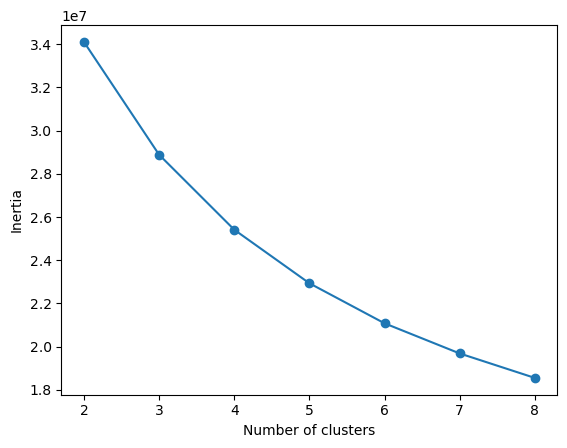

In [168]:
# Define range of cluster numbers to try
cluster_range = range(2, 9)

# Initialize list to store inertia values for each cluster number
inertia_values = []

# Loop over cluster numbers and fit KMeans model
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot elbow plot
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [169]:
# Fit KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Add cluster labels to original dataset
df['cluster'] = cluster_labels

# Define cluster names
#cluster_names = {
#    0: 'Platinum',
#    1: 'Gold',
#    2: 'Silver'
#}

# Map cluster labels to cluster names
#df['cluster_name'] = df['cluster'].map(cluster_names)

In [147]:
df.head()

,customer_id,province,gender,age_group,current_reward_points,transaction_date,start_reward_points,end_reward_points,spend_type,shopping_category,spend,province_population,customer_density,cluster
0,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-06,10029,5740,redemption,electronics,0,5851754,0.001876,0
1,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-22,10029,10208,debit,electronics,446800,5851754,0.001876,0
2,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-13,10029,13410,credit,sports,320200,5851754,0.001876,1
3,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-09,10029,16673,credit,electronics,326300,5851754,0.001876,0
4,88A873BD-B46E-4607-AD7C-0B3F0397DD6F,Wisconsin,female,41-45,10980,2022-01-21,10029,21001,credit,electronics,432800,5851754,0.001876,0


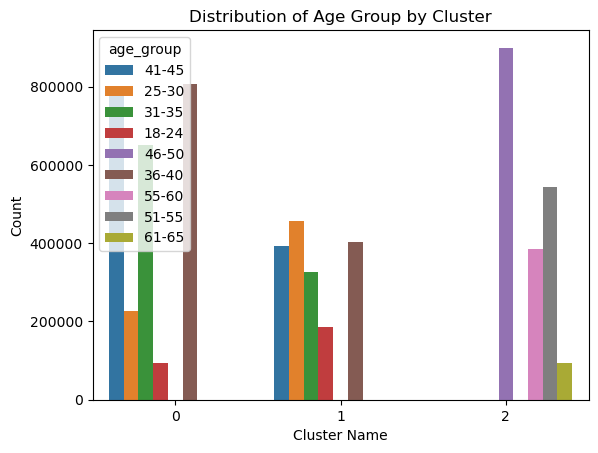

In [170]:
# Define order of age groups
#age_order = ['18-24', '25-30', '31-35','36-40', '41-45','46-50', '51-55','56-60', '61-65']

# Create countplot of age group by cluster
sns.countplot(data=df, x='cluster', hue='age_group')

# Add title and axes labels
plt.title('Distribution of Age Group by Cluster')
plt.xlabel('Cluster Name')
plt.ylabel('Count')

# Display plot
plt.show()


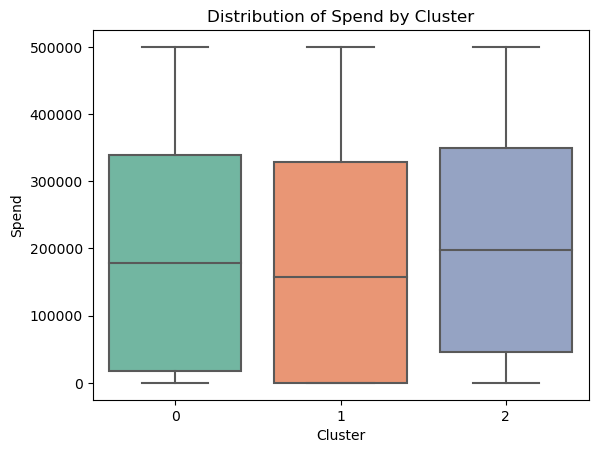

In [171]:
# Create boxplot of spend by cluster
sns.boxplot(data=df, x='cluster', y='spend', palette='Set2')

# Add title and axes labels
plt.title('Distribution of Spend by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spend')

# Display plot
plt.show()

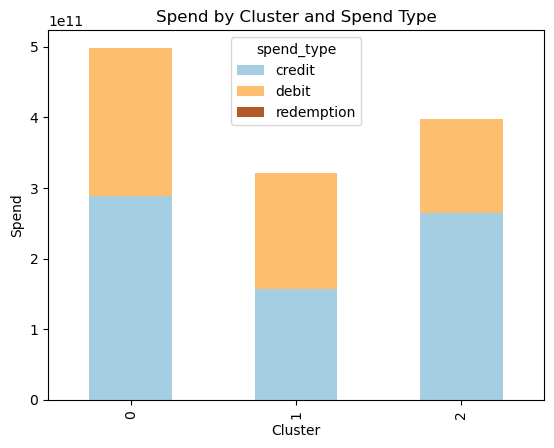

In [172]:
# Group the data by cluster and spend type, and sum the spend amounts
grouped = df.groupby(['cluster', 'spend_type']).sum().reset_index()

# Pivot the data to create a wide-form dataframe
pivoted = grouped.pivot(index='cluster', columns='spend_type', values='spend')

# Create grouped barplot of credit, debit, and redemption spends by cluster
pivoted.plot(kind='bar', stacked=True, colormap='Paired')

# Add title and axes labels
plt.title('Spend by Cluster and Spend Type')
plt.xlabel('Cluster')
plt.ylabel('Spend')

# Display plot
plt.show()

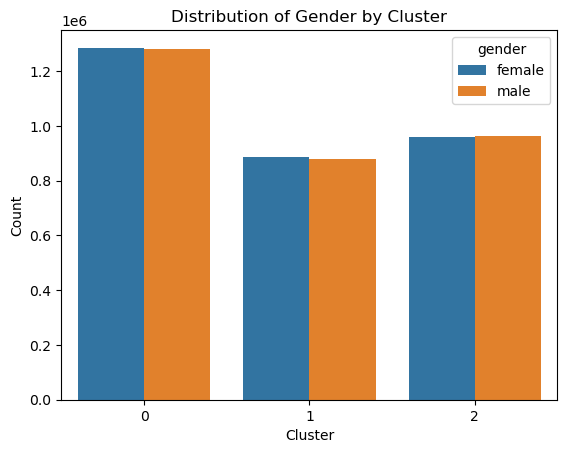

In [173]:
# Create countplot of gender by cluster
sns.countplot(data=df, x='cluster', hue='gender')

# Add title and axes labels
plt.title('Distribution of Gender by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Display plot
plt.show()

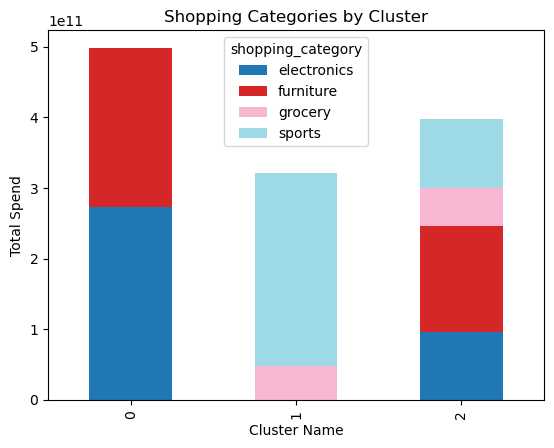

In [174]:
# Create a pivot table with cluster and shopping category
pivot_table = pd.pivot_table(data=df, values='spend', index='cluster', columns='shopping_category', aggfunc='sum')

# Plot stacked bar chart
pivot_table.plot(kind='bar', stacked=True, cmap='tab20')

# Set title and axis labels
plt.title('Shopping Categories by Cluster')
plt.xlabel('Cluster Name')
plt.ylabel('Total Spend')

# Display plot
plt.show()

   cluster   count
0        0  577691
1        1  482462
2        2  336345


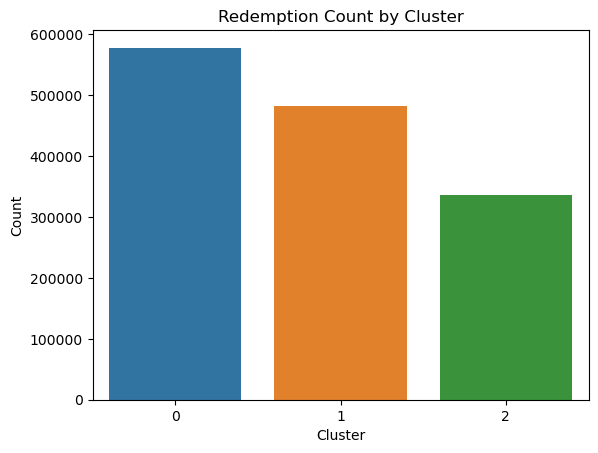

In [175]:
redemption_counts = df[df['spend_type'] == 'redemption'].groupby('cluster').size().reset_index(name='count')
print(redemption_counts)

sns.barplot(x='cluster', y='count', data=redemption_counts)

# Add title and axes labels
plt.title('Redemption Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Display plot
plt.show()
